<a href="https://colab.research.google.com/github/catalinakarinip/mercadolabroal/blob/main/mercadolaboral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1: Limpieza bases INE

Para actualizar las bases limpias se debe
1. Subir las bbdd originales del INE
2. Ver si la base de diccionario "variables_por_base" mantiene las columnas, y por tanto las abreviaturas corresponden
3. Cambiar nombre del archivo al compatible con la base de diccionario

El code se demora 1 min en crear todas las bases limpias!!


In [16]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# ================= 1. LIBRERÍAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_originales"
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["Año", "Trimestre"]
HOJAS_OBJETIVO = {
    "AS",
    "AP",
    "TA",
    "AN",
    "AT",
    "CO",
    "VA",
    "RM",
    "LI",
    "ML",
    "NB",
    "BI",
    "AR",
    "LR",
    "LL",
    "AI",
    "MA",
}

# ================= 5. CONVERSIÓN NÚMEROS LATINOS =======================

LATIN_NUMBER_RE = re.compile(r"^\d{1,3}(\.\d{3})*(,\d+)?$")

def texto_a_numero(valor: str):
    if pd.isna(valor):
        return None
    texto = str(valor)
    if LATIN_NUMBER_RE.match(texto):
        texto = texto.replace(".", "").replace(",", ".")
    else:
        texto = texto.replace(",", ".")
    try:
        return float(texto)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    # Normalize quarter names so they match TRIM_OK in unify_panel.py
    quarter_map = {
        "1": "Ene - Mar",
        "2": "Abr - Jun",
        "3": "Jul - Sep",
        "4": "Oct - Dic",
        "ene-mar": "Ene - Mar",
        "abr-jun": "Abr - Jun",
        "jul-sep": "Jul - Sep",
        "oct-dic": "Oct - Dic",
        "ene - mar": "Ene - Mar",
        "abr - jun": "Abr - Jun",
        "jul - sep": "Jul - Sep",
        "oct - dic": "Oct - Dic",
    }
    df["Trimestre"] = (
        df["Trimestre"].astype(str).str.strip().str.lower().replace(quarter_map)
    )
    df["Año"] = pd.to_numeric(df["Año"], errors="coerce")

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists():
            print(f"↻  Reemplazando {dest.name}")
        else:
            print(f"→ Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"⚠️ Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"⚠️ Ninguna hoja válida guardada en {src.name}")
    print("\n✅ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()



↻  Reemplazando rama_limpia.xlsx
↻  Reemplazando informalidadtasas_limpia.xlsx
↻  Reemplazando informalidadrama_limpia.xlsx
↻  Reemplazando informalidadgrupo_limpia.xlsx
↻  Reemplazando informalidadcategoria_limpia.xlsx
↻  Reemplazando indicadoresprincipales_limpia.xlsx
↻  Reemplazando grupo_limpia.xlsx
↻  Reemplazando complementarios_limpia.xlsx
↻  Reemplazando categoria_limpia.xlsx

✅ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios


# Script 2.1: Panel de datos

In [40]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# ================= 1. LIBRERÍAS Y PATH ========================================
from pathlib import Path
import pandas as pd
ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
PANEL_FILE = ROOT / "resultados" / "panel_ENE_unificado.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA = {
    "AP": "Arica y Parinacota",
    "TA": "Tarapacá",
    "AN": "Antofagasta",
    "AT": "Atacama",
    "CO": "Coquimbo",
    "VA": "Valparaíso",
    "RM": "Región Metropolitana",
    "LI": "O’Higgins",
    "ML": "Maule",
    "NB": "Ñuble",
    "BI": "Biobío",
    "AR": "Araucanía",
    "LR": "Los Ríos",
    "LL": "Los Lagos",
    "AI": "Aysén",
    "MA": "Magallanes",
    "AS": "Nacional",
}
REGIONES = set(MAPA.keys())
ID_VARS = ["Año", "Trimestre", "region_code", "region_name"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# ================= 2.MAPEO INICIAL ===========================

def cargar_base(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in REGIONES:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["region_code"] = hoja
        df["region_name"] = MAPA[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)


# ================= 3. CONSTRUCCIÓN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")
    if panel is None:
        print("No se encontraron archivos limpios")
        return
    panel["Trimestre_num"] = panel["Trimestre"].map(TRIM_MAP)
    panel = (
        panel.sort_values(
            ["Año", "Trimestre_num", "region_code", "region_name"]
        )
        .drop(columns="Trimestre_num")
        .reset_index(drop=True)
    )
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["Año"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q",
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time
    #panel["Periodo_str"] = panel["Periodo"].astype(str)

    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"↻  Reemplazando {PANEL_FILE.name}")
    panel.to_excel(PANEL_FILE, index=False, sheet_name="panel_data")
    print("✅ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()

<ipython-input-41-1241934044>:72: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  panel["Periodo"] = pd.PeriodIndex(


↻  Reemplazando panel_ENE_unificado.xlsx
✅ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx


# Script 2.2: Panel BioBio vs Nacional

In [45]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir orden temporal
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df = df.sort_values(["Año", "Trimestre_num", "region_name"])

# Seleccionar columnas en orden
cols_final = ['Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


In [47]:
# ================= Panel Biobío vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biobío', 'Nacional'])].copy()

# Añadir periodo y fecha
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df["Periodo"] = pd.PeriodIndex.from_fields(
    year=df["Año"],
    quarter=df["Trimestre_num"],
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time

# Ordenar y seleccionar columnas finales
df = df.sort_values(["Periodo", "region_name"])
cols_final = ['Periodo', 'Fecha', 'Año', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"✅ Hoja «biobio_vs_nacional» creada con {len(df_panel)} filas.")


✅ Hoja «biobio_vs_nacional» creada con 122 filas.


# Script 3: BBDD anual 2024

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2024
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)

df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)


# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2024» (68 filas) y «promedios_2024» (17 regiones) creadas/actualizadas.


# Script 4: BBDD anual 2025

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
import pandas as pd

# 1️⃣  Parámetros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2025
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2️⃣  Leer la hoja principal y filtrar solo el año objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("Año == @anio")
)
df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("Año == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["Año"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)

# 3️⃣  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4️⃣  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"✅ Hoja «{hoja_filtrada}» ({len(df_anio)} filas) y «{hoja_prom}» ({len(promedios)} regiones) creadas/actualizadas.")

✅ Hoja «data_2025» (17 filas) y «promedios_2025» (17 regiones) creadas/actualizadas.


# Funciones

In [55]:
# ========== CALCULAR VARIACIONES INTERANUALES ==========

from pathlib import Path
import pandas as pd

TRIM_MAP = {
    "Ene - Mar": 1,
    "Abr - Jun": 2,
    "Jul - Sep": 3,
    "Oct - Dic": 4,
}

# === Función para cargar y crear columna Periodo si no existe ===
def load_panel_variaciones(path: Path, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    if "Periodo" not in df.columns:
        df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
        df["Periodo"] = pd.PeriodIndex(
            year=df["Año"],
            quarter=df["Trimestre_num"],
            freq="Q"
        )
    return df

# === Calcular variaciones ===
def add_variations(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    df = df.sort_values(["region_name", "Periodo"]).copy()
    for var in variables:
        # Variación interanual: diferencia con el mismo trimestre del año anterior
        df[f"{var}_da"] = df.groupby("region_name")[var].diff(periods=4)
    return df


    return df

# === Ruta y columnas a calcular ===
PANEL_FILE = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx')
SHEET_IN = "biobio_vs_nacional"
SHEET_OUT = "biobio_vs_nacional_variaciones"

# Cargar panel
df = load_panel_variaciones(PANEL_FILE, SHEET_IN)

# Seleccionar solo las columnas numéricas de interés (excluyendo Año, Fecha, etc.)
cols_num = df.select_dtypes("number").columns.difference(["Año", "Trimestre_num"])
df_var = add_variations(df, cols_num)

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_var.to_excel(writer, sheet_name=SHEET_OUT, index=False)

print(f"✅ Hoja «{SHEET_OUT}» creada con variaciones.")


✅ Hoja «biobio_vs_nacional_variaciones» creada con variaciones.


# Gráficos

🔍 Buscando fuentes DM Sans en Google Drive...
   📁 Revisando: /content/drive/MyDrive/Data/fonts
   ✅ Encontrada: DMSans-Regular.ttf
   ✅ Encontrada: DMSans-Bold.ttf
   ✅ Encontrada: DMSans-Italic.ttf
✅ Registrada: DMSans-Regular.ttf → 'DM Sans'
✅ Registrada: DMSans-Bold.ttf → 'DM Sans'
✅ Registrada: DMSans-Italic.ttf → 'DM Sans'

🎯 Configurando 'DM Sans' como fuente principal
✅ DM Sans configurado exitosamente
✅ Datos cargados desde Excel


<Figure size 640x480 with 0 Axes>

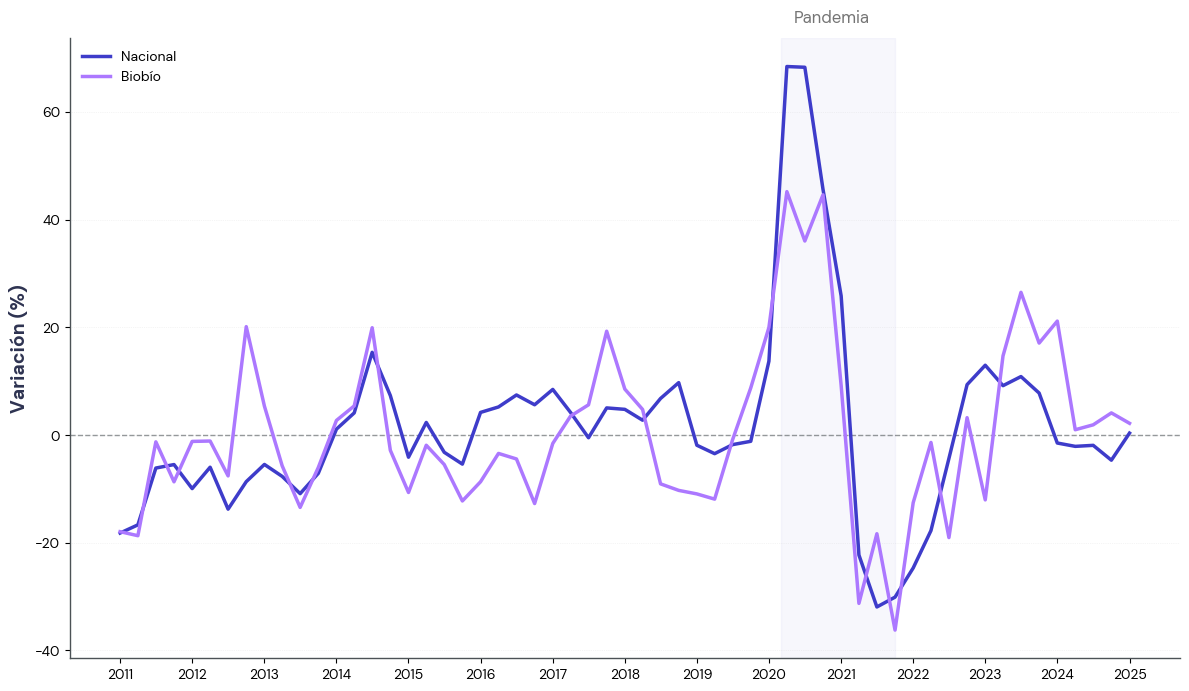


🎨 Fuente configurada: DM Sans
🎨 Fuente en título: DM Sans
📊 Total fuentes registradas: 3
✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


In [43]:
# ─── 1. Cargar DM Sans desde Google Drive ─────────────────────────────────────
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("🔍 Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   📁 Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ✅ Encontrada: {font_file}")
    else:
        print(f"   ⚠️ No existe: {font_dir}")

# ─── 2. Registrar fuentes encontradas ──────────────────────────────────────────
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"✅ Registrada: {font_path.name} → '{font_name}'")

    except Exception as e:
        print(f"❌ Error registrando {font_path.name}: {e}")

# ─── 3. Configurar matplotlib para usar DM Sans ───────────────────────────────
if dm_font_name:
    print(f"\n🎯 Configurando '{dm_font_name}' como fuente principal")

    # Método 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # Método 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("✅ DM Sans configurado exitosamente")


# ─── 4. Configuración de datos y paleta ───────────────────────────────────────
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ─── 5. Cargar y procesar datos ────────────────────────────────────────────────
try:
    df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
    df["Fecha"] = pd.to_datetime(df["Fecha"])
    df.sort_values("Fecha", inplace=True)

    def interanual(s):
        return s.pct_change(4) * 100

    nac = df[df["region_name"]=="Nacional"].copy()
    bio = df[df["region_name"]=="Biobío"].copy()
    nac["var"] = interanual(nac["T_TDO_indicadoresprincipales"])
    bio["var"] = interanual(bio["T_TDO_indicadoresprincipales"])

    print("✅ Datos cargados desde Excel")

except FileNotFoundError:
    print("⚠️ Archivo Excel no encontrado. Usando datos sintéticos...")
    dates = pd.date_range('2020-01-01', '2024-12-01', freq='MS')
    np.random.seed(42)
    nac = pd.DataFrame({
        'Fecha': dates,
        'var': np.random.randn(len(dates)).cumsum() * 0.3 + np.sin(np.arange(len(dates)) * 0.1) * 2
    })
    bio = pd.DataFrame({
        'Fecha': dates,
        'var': np.random.randn(len(dates)).cumsum() * 0.4 + np.sin(np.arange(len(dates)) * 0.12) * 1.5 + 0.5
    })

# ─── 6. Crear gráfico con DM Sans ──────────────────────────────────────────────

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Sombreado leve para pandemia (muy tenue y atrás)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# Líneas principales
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biobío",   color=PALETTE[6], linewidth=2.5, zorder=2)

# Línea horizontal en cero (más destacada)
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto “Pandemia” desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,  # un poquito más alto
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)


# Eje Y
ax.set_ylabel("Variación (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # más grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: líneas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()



# ─── 7. Verificar fuente y mostrar ─────────────────────────────────────────────
print(f"\n🎨 Fuente configurada: {dm_font_name}")
print(f"🎨 Fuente en título: {ax.title.get_fontname()}")
print(f"📊 Total fuentes registradas: {len(registered_fonts)}")

plt.show()

# ─── 8. Guardar gráfico ────────────────────────────────────────────────────────
try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✅ Gráfico guardado: {OUT_FILE}")
except Exception as e:
    backup_path = Path("./variacion_tdo_dmsans.png")
    plt.savefig(backup_path, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"📁 Guardado como respaldo: {backup_path}")

<Figure size 640x480 with 0 Axes>

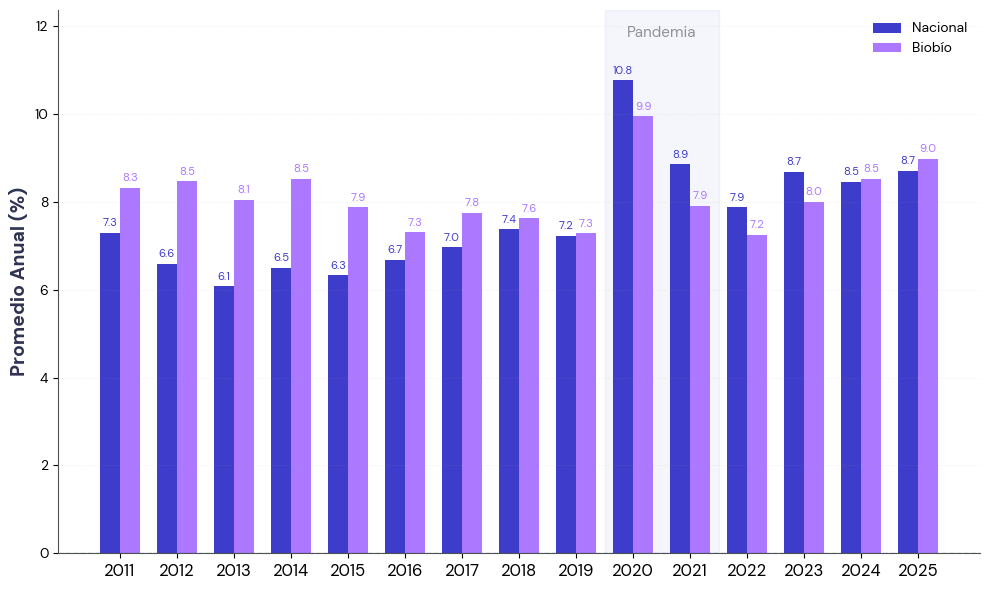

✅ Gráfico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


In [64]:
# ─── 1. Configuración inicial ─────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Paleta institucional
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# Paths
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

# ─── 2. Cargar fuentes DM Sans desde Drive ────────────────────────────────────
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ─── 3. Cargar datos y calcular promedio anual ────────────────────────────────
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["Año"] = df["Fecha"].dt.year

prom = df.groupby(["Año", "region_name"])["T_TDO_indicadoresprincipales"].mean().unstack()
prom = prom[prom.index >= 2011]  # Puedes ajustar este filtro

# ─── 4. Gráfico de barras ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(prom.index))

# Barras
ax.bar(x - bar_width/2, prom["Nacional"], width=bar_width,
       color=PALETTE[3], label="Nacional")
ax.bar(x + bar_width/2, prom["Biobío"], width=bar_width,
       color=PALETTE[6], label="Biobío")

# Eje X
ax.set_xticks(x)
ax.set_xticklabels(prom.index, fontproperties=dm_font_props, fontsize=12)

# Eje Y
ax.set_ylabel("Promedio Anual (%)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.tick_params(axis='y', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Línea cero y rejilla
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Sombreado pandemia
x_dict = {año: i for i, año in enumerate(prom.index)}
if 2020 in x_dict and 2021 in x_dict:
    ax.axvspan(x_dict[2020] - 0.5, x_dict[2021] + 0.5,
               color=PALETTE[3], alpha=0.05, zorder=0)

# Layout antes de insertar texto para conocer los límites
plt.tight_layout()
plt.draw()  # <-- Importante para actualizar ax.get_ylim()

# 1. Subimos límite del eje Y con margen cómodo
y_max = prom.max().max() + 1.6
ax.set_ylim(0, y_max)

# 2. Texto “Pandemia” más arriba, sin superposición
ax.text(x_centro, y_max * 0.97,
        "Pandemia", ha="center", va="top",
        fontsize=11, fontproperties=dm_font_props,
        color=PALETTE[0], alpha=0.6)

# 3. Etiquetas sobre barras, más espaciadas
for i, año in enumerate(prom.index):
    nac_val = prom.loc[año, "Nacional"]
    bio_val = prom.loc[año, "Biobío"]

    ax.text(x[i] - bar_width/2, nac_val + 0.15, f"{nac_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[3])

    ax.text(x[i] + bar_width/2, bio_val + 0.15, f"{bio_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[6])

# Leyenda
ax.legend(frameon=False, loc="upper right",
          prop=dm_font_props, fontsize=12)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Mostrar y guardar
plt.show()

try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"✅ Gráfico guardado: {OUT_FILE}")
except Exception as e:
    print(f"⚠️ Error al guardar: {e}")


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
